In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
#fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 12)
import matplotlib.dates as mdates
import datetime

Using TensorFlow backend.


In [40]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '2009-01-01', '2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_2

In [41]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close    Volume
0     0  2009-01-02  16.401867  50084000
1     1  2009-01-05  16.555156  61475200
2     2  2009-01-06  16.748784  58083400
3     3  2009-01-07  15.740307  72709900
4     4  2009-01-08  16.232444  70255400
---
      Item        Date  Adj_Close    Volume
1621  1621  2015-06-12  43.885499  23931000
1622  1622  2015-06-15  43.417717  33254500
1623  1623  2015-06-16  43.751848  27070300
1624  1624  2015-06-17  43.885499  28704100
1625  1625  2015-06-18  44.601491  32658300


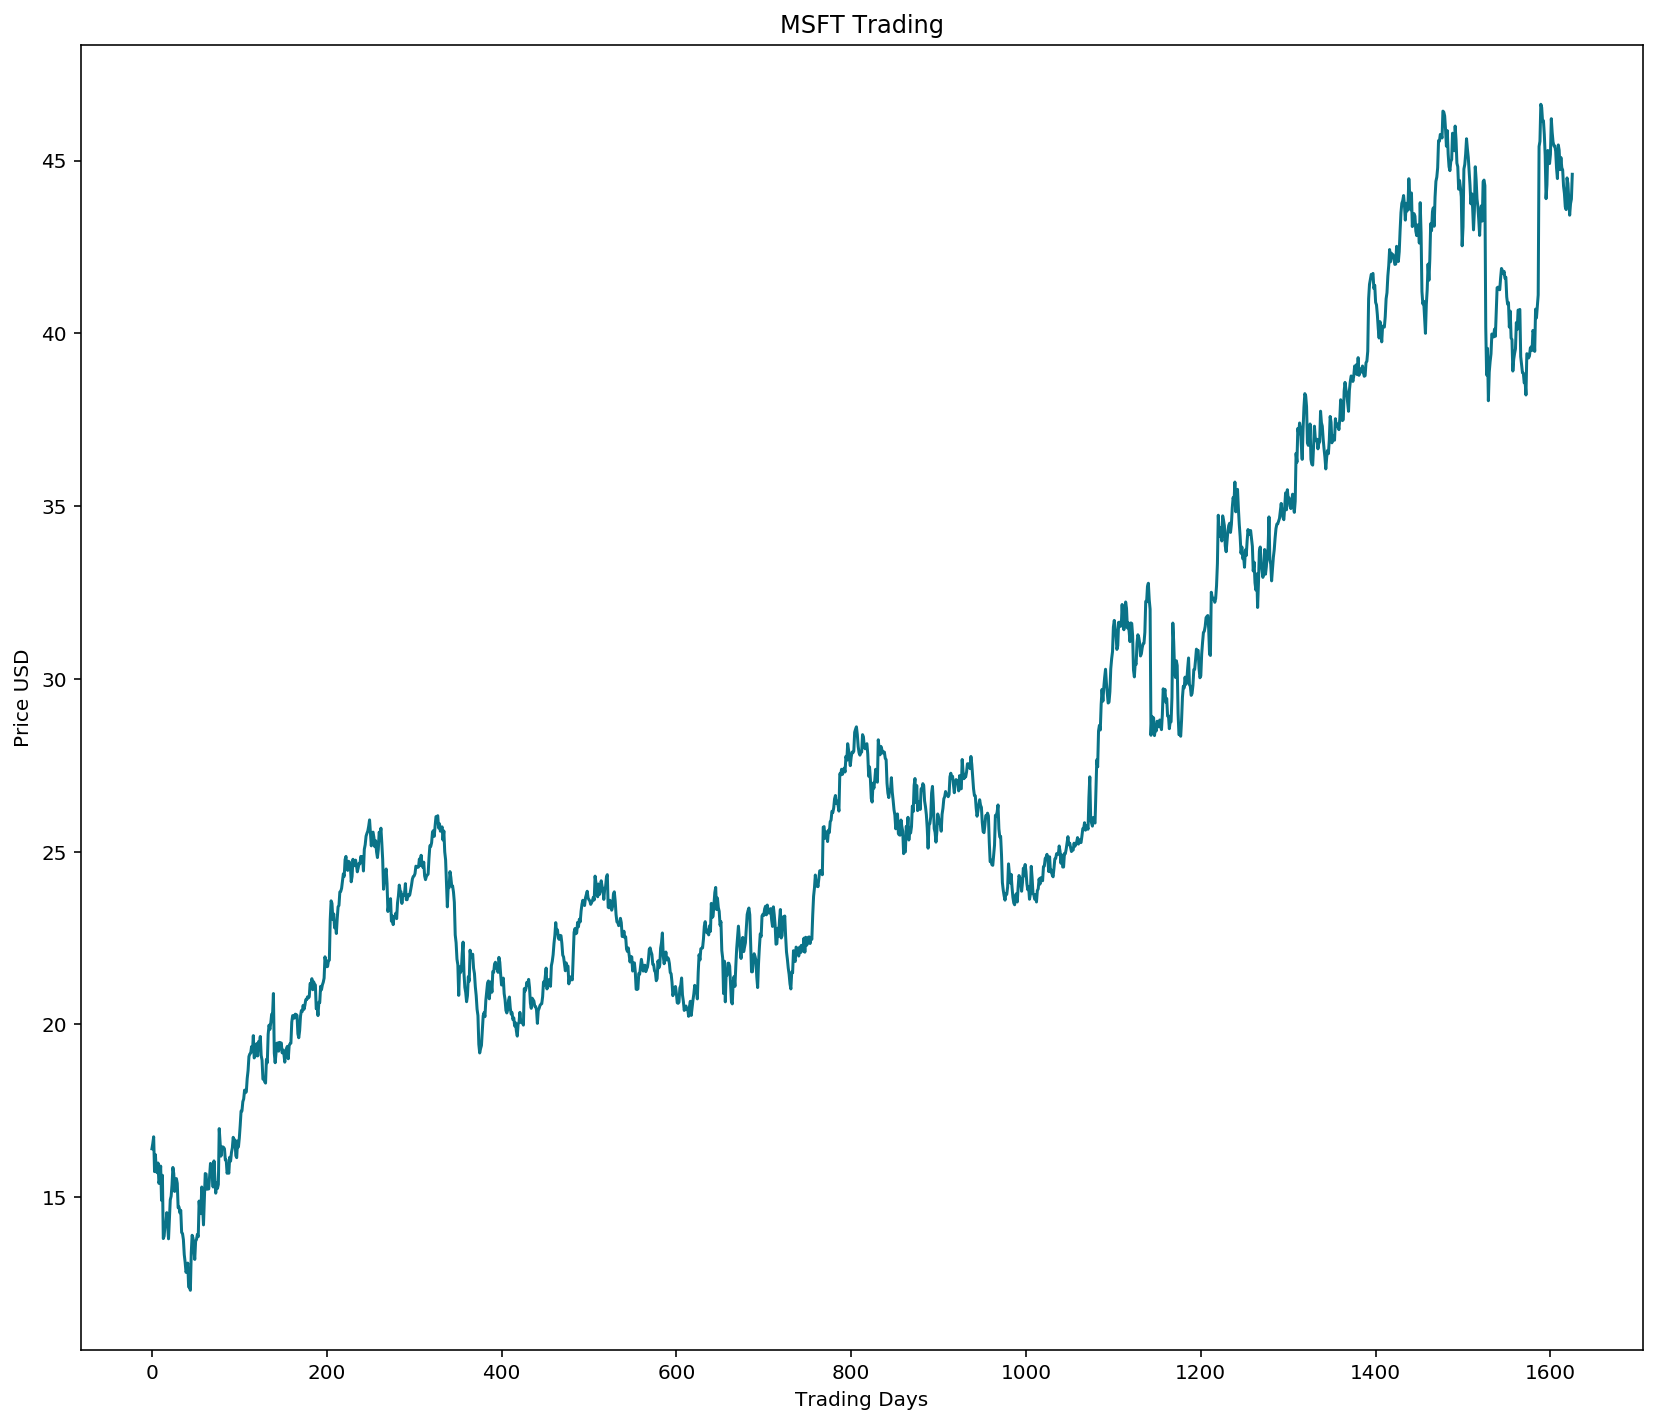

In [42]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.set_title(base_ticker + ' Trading')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

In [43]:
#Create numpy arrays for features and targets
X_all = []
y_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_all.append([(row['Item'])])
    y_all.append([(row['Adj_Close'])])

#pprint(X_all)
pprint(y_all)

[[16.401867000000003],
 [16.555156],
 [16.748784],
 [15.740307000000001],
 [16.232444],
 [15.748375],
 [15.708035],
 [15.990409],
 [15.401457999999998],
 [15.522475],
 [15.901662],
 [14.909320999999998],
 [15.635423999999999],
 [13.804031],
 [13.876642000000002],
 [14.223557000000001],
 [14.247760999999999],
 [14.554338000000001],
 [14.191285999999998],
 [13.795963],
 [14.384914000000002],
 [14.925457000000002],
 [15.030338],
 [15.361120000000001],
 [15.861324],
 [15.683832],
 [15.167491],
 [15.498270999999999],
 [15.538610999999998],
 [15.401457999999998],
 [14.694745999999999],
 [14.719116],
 [14.548529],
 [14.621638],
 [13.979909],
 [13.947417999999999],
 [13.776831],
 [13.338182999999999],
 [13.118858],
 [12.826425],
 [12.899534],
 [13.094489],
 [12.404023],
 [12.412144999999999],
 [12.306545],
 [13.386921],
 [13.898679000000001],
 [13.817448],
 [13.525014],
 [13.200089000000002],
 [13.728093],
 [13.776831],
 [13.923048000000001],
 [13.858063000000001],
 [14.889701],
 [14.564776],


In [44]:
# Scale function
def scale_range(X, input_range=[0.0,1.0], target_range=[0.0,1.0]):
    """
    Scales a numpy array to a new target range
    X = array of numbers
    target_range = new target min and max, default (0.0, 1.0)
    """
    orig_range = [X.min(axis=0),X.max(axis=0)]
    orig_range = [orig_range[0][0], orig_range[1][0]]
    X_std = (X - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    X_scaled = X_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return X_scaled, orig_range
    

In [45]:
# Regularize the feature and target arrays and store min/max of input data for rescaling later
X_bounds = [min(X_all), max(X_all)]
X_bounds = [X_bounds[0][0], X_bounds[1][0]]
y_bounds = [min(y_all), max(y_all)]
y_bounds = [y_bounds[0][0], y_bounds[1][0]]

X_scaled, X_range = scale_range(np.array(X_all), input_range=X_bounds, target_range=[-1.0, 1.0])
y_scaled, y_range = scale_range(np.array(y_all), input_range=y_bounds, target_range=[-1.0, 1.0])

pprint(y_scaled)
print(y_range)

array([[-0.76135371],
       [-0.75242112],
       [-0.74113785],
       ..., 
       [ 0.832409  ],
       [ 0.84019724],
       [ 0.88192017]])
[12.306545, 46.627815999999996]


In [46]:
# Define Test/Train Split 80/20
tt_split = .20
tti_split = int(math.floor(len(stock_df['Item'])*tt_split))

# Set up training and test sets
X_train = X_scaled[:-tti_split]
X_test = X_scaled[-tti_split:]
print(len(X_train))
print(len(X_test))

y_train = y_scaled[:-tti_split]
y_test = y_scaled[-tti_split:]

#pprint(X_train)
#pprint(X_test)

# Create dataframe for all training, testing, and predicted sets
results_df = pd.DataFrame(columns=['Item', 'Actual', 'Actual_Scaled', 'Train', 'Test', 'Test_Scaled', 'Predicted', 'Predicted_Scaled'])
results_df['Item'] = stock_df['Item']
results_df['Actual'] = stock_df['Adj_Close']
results_df['Actual_Scaled'] = y_scaled.flatten()
results_df['Train'][:-tti_split] = y_train.flatten()
results_df['Test'][-tti_split:] = stock_df['Adj_Close'][-tti_split:]
results_df['Test_Scaled'][-tti_split:] = y_test.flatten()

pprint(results_df)


1301
325
      Item     Actual  Actual_Scaled     Train     Test Test_Scaled Predicted  \
0        0  16.401867      -0.761354 -0.761354      NaN         NaN       NaN   
1        1  16.555156      -0.752421 -0.752421      NaN         NaN       NaN   
2        2  16.748784      -0.741138 -0.741138      NaN         NaN       NaN   
3        3  15.740307      -0.799905 -0.799905      NaN         NaN       NaN   
4        4  16.232444      -0.771226 -0.771226      NaN         NaN       NaN   
5        5  15.748375      -0.799435 -0.799435      NaN         NaN       NaN   
6        6  15.708035      -0.801785 -0.801785      NaN         NaN       NaN   
7        7  15.990409      -0.785331 -0.785331      NaN         NaN       NaN   
8        8  15.401458      -0.819650  -0.81965      NaN         NaN       NaN   
9        9  15.522475      -0.812598 -0.812598      NaN         NaN       NaN   
10      10  15.901662      -0.790502 -0.790502      NaN         NaN       NaN   
11      11  14.9093

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [48]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(y_test, look_back)

pprint(trainX)
print('--')
pprint(trainY)

array([[-1.        , -0.99876923, -0.99753846],
       [-0.99876923, -0.99753846, -0.99630769],
       [-0.99753846, -0.99630769, -0.99507692],
       ..., 
       [ 0.59261538,  0.59384615,  0.59507692],
       [ 0.59384615,  0.59507692,  0.59630769],
       [ 0.59507692,  0.59630769,  0.59753846]])
--
array([-0.99630769, -0.99507692, -0.99384615, ...,  0.59630769,
        0.59753846,  0.59876923])


In [49]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

# Create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=2)

Epoch 1/200
0s - loss: 0.0459
Epoch 2/200
0s - loss: 0.0026
Epoch 3/200
0s - loss: 0.0017
Epoch 4/200
0s - loss: 6.4143e-04
Epoch 5/200
0s - loss: 6.2325e-05
Epoch 6/200
0s - loss: 9.6407e-06
Epoch 7/200
0s - loss: 7.2533e-06
Epoch 8/200
0s - loss: 6.2111e-06
Epoch 9/200
0s - loss: 4.9381e-06
Epoch 10/200
0s - loss: 3.7257e-06
Epoch 11/200
0s - loss: 2.5785e-06
Epoch 12/200
0s - loss: 1.7919e-06
Epoch 13/200
0s - loss: 1.0933e-06
Epoch 14/200
0s - loss: 7.4221e-07
Epoch 15/200
0s - loss: 2.2825e-06
Epoch 16/200
0s - loss: 4.2051e-07
Epoch 17/200
0s - loss: 5.6445e-07
Epoch 18/200
0s - loss: 2.7348e-06
Epoch 19/200
0s - loss: 1.0588e-06
Epoch 20/200
1s - loss: 4.4252e-06
Epoch 21/200
0s - loss: 4.8557e-07
Epoch 22/200
1s - loss: 1.2839e-06
Epoch 23/200
1s - loss: 1.6449e-06
Epoch 24/200
0s - loss: 1.2154e-07
Epoch 25/200
0s - loss: 2.6321e-06
Epoch 26/200
0s - loss: 6.0938e-07
Epoch 27/200
0s - loss: 1.2278e-06
Epoch 28/200
0s - loss: 2.0443e-06
Epoch 29/200
0s - loss: 2.9862e-08
Epoch 

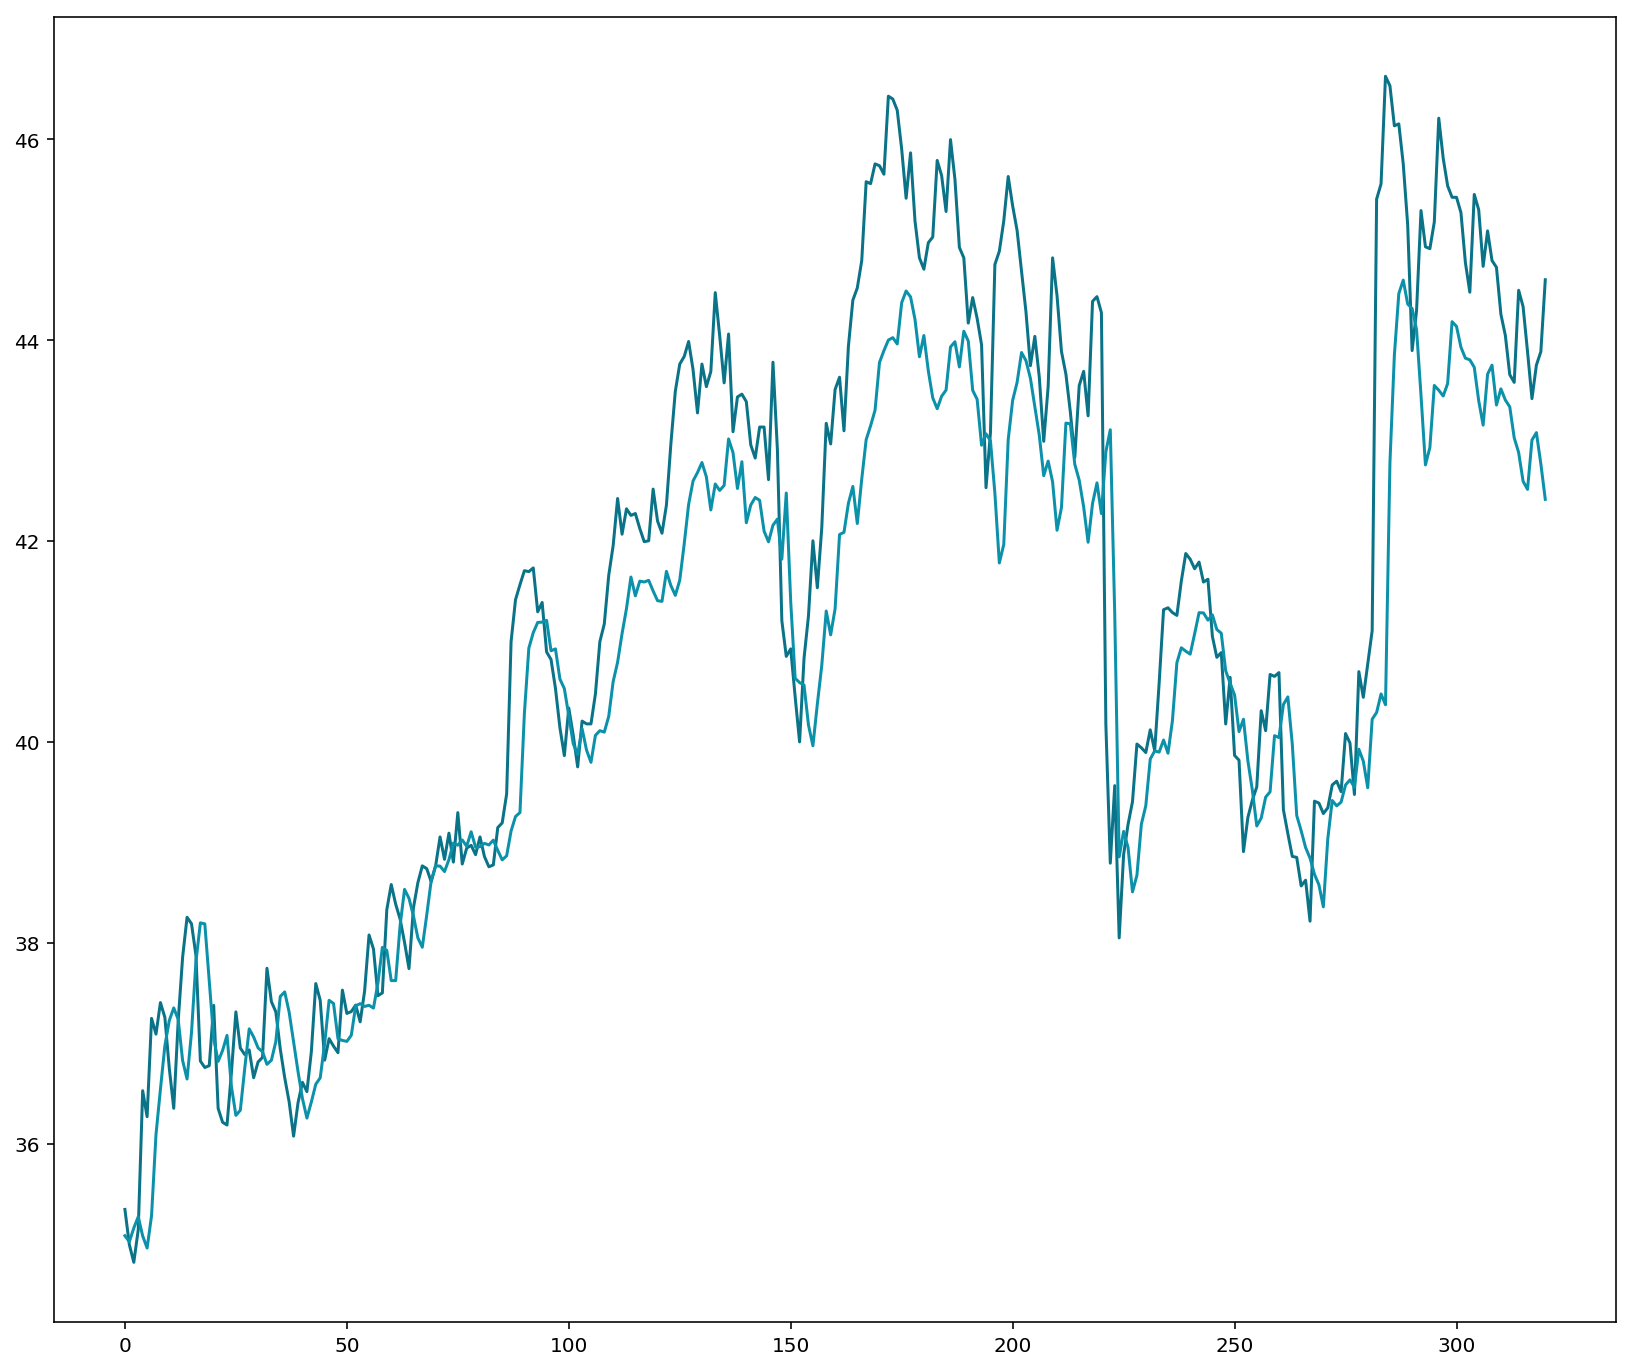

In [50]:
# Generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict_rescaled, r1 = scale_range(np.array(trainPredict), input_range=[-1.0, 1.0], target_range=y_bounds)
testPredict_rescaled, r2 = scale_range(np.array(testPredict), input_range=[-1.0, 1.0], target_range=y_bounds)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_rescaled)+look_back, :] = trainPredict_rescaled
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_scaled)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(testPredict_rescaled)+(look_back*2)+1:len(X_scaled)-1, :] = testPredict_rescaled

# plot baseline and predictions
plt.plot(y_all[-len(testPredict_rescaled):],'#0A7388')
#plt.plot(trainPredictPlot, '#2FBA9C')
plt.plot(testPredict_rescaled,  '#0C91AB')
plt.show()

In [51]:
# The mean squared error
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.3f MSE (%.3f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.005 MSE (0.068 RMSE)


# Log of Results:
Lookback: 3

### SPY
Mean squared error: 0.002


### GE
Mean squared error: 0.002


### MSFT
Mean squared error: 0.005


### AAPL
Mean squared error: 0.002

